In [129]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
import cv2 as cv
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs


# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# from utils import io, abi, glm, nexrad
from utils import io, abi, glm, nexrad
from utils.plotting import goes_figure
from utils.flow import Flow
from utils import legacy_flow as lf

# Filter some warnings because pyart doesn't work nicely with notebooks

import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

Figure 1: Examples of growing, mature and dissipating convection in satellite, radar and lightning signature

In [9]:
# Load files
goes_data_path = './data/GOES16'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'
start_date = datetime(2018,6,19,17)
days = timedelta(days=0.16)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()

abi_files = list(sum([sorted(io.find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=3, 
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))
             

abi_dates = [io.get_goes_date(i) for i in abi_files]
print(len(abi_files))

# Get time difference (in seconds) between each file
dt = [(abi_dates[1]-abi_dates[0]).total_seconds()/60] \
     + [(abi_dates[i+2]-abi_dates[i]).total_seconds()/120 \
        for i in range(len(abi_files)-2)] \
     + [(abi_dates[-1]-abi_dates[-2]).total_seconds()/60]
dt = np.array(dt)

# Test with some multichannel data
ds_slice = {'x':slice(1325,1475), 'y':slice(725,850)}
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)
wvd = goes_ds.CMI_C08 - goes_ds.CMI_C10
bt = goes_ds.CMI_C13
swd = goes_ds.CMI_C13 - goes_ds.CMI_C15

48


In [232]:
# Get GLM data
# Process new GLM data
glm_files = sorted(sum([sorted(io.find_glm_files(date, satellite=16,
                                     save_dir=goes_data_path,
                                     replicate_path=True, check_download=True,
                                     n_attempts=1, download_missing=True))
                 for date in dates], []))
glm_files = {io.get_goes_date(i):i for i in glm_files}
glm_grid = glm.regrid_glm(glm_files, goes_ds, corrected=False)

In [112]:
h = goes_ds.goes_imager_projection.perspective_point_height
glm_xy = [[np.concatenate(locs)*h for locs in zip(*[glm.get_uncorrected_glm_x_y(glm_files[ft], goes_ds)
                                                  for ft in glm_files 
                                                  if ft >= abi_dates[i]-timedelta(minutes=2.5) 
                                                      and ft < abi_dates[i]+timedelta(minutes=2.5)])]
         for i in [0,6,18,-1]]

In [73]:
# Get Nexrad data
nexrad_data_path = './data/nexrad_l2'
print('Finding NEXRAD data')
nexrad_sites = nexrad.filter_nexrad_sites(goes_ds,extend=0.0025)
print("Number of sites in bound: %d" % len(nexrad_sites))
nexrad_files = sum([sum([io.find_nexrad_files(date, site, save_dir=nexrad_data_path, download_missing=True)
                         for site in nexrad_sites], [])
                    for date in dates], [])

Finding NEXRAD data
Number of sites in bound: 6


In [76]:
ref_grid, ref_mask = nexrad.regrid_nexrad(nexrad_files, goes_ds, min_alt=500)

2020-11-30 18:26:08.827737 ./data/nexrad_l2/2018/06/19/KJAX/NWS_NEXRAD_NXL2DPBL_KJAX_20180619170000_20180619175959.tar
2020-11-30 18:28:05.357166 ./data/nexrad_l2/2018/06/19/KTLH/NWS_NEXRAD_NXL2DPBL_KTLH_20180619170000_20180619175959.tar
2020-11-30 18:32:18.140412 ./data/nexrad_l2/2018/06/19/KTBW/NWS_NEXRAD_NXL2DPBL_KTBW_20180619170000_20180619175959.tar
2020-11-30 18:36:49.505549 ./data/nexrad_l2/2018/06/19/KEOX/NWS_NEXRAD_NXL2DPBL_KEOX_20180619170000_20180619175959.tar
2020-11-30 18:39:01.474365 ./data/nexrad_l2/2018/06/19/KJAX/NWS_NEXRAD_NXL2DPBL_KJAX_20180619180000_20180619185959.tar
2020-11-30 18:43:45.296636 ./data/nexrad_l2/2018/06/19/KTLH/NWS_NEXRAD_NXL2DPBL_KTLH_20180619180000_20180619185959.tar
2020-11-30 18:48:28.903693 ./data/nexrad_l2/2018/06/19/KTBW/NWS_NEXRAD_NXL2DPBL_KTBW_20180619180000_20180619185959.tar
2020-11-30 18:52:27.351760 ./data/nexrad_l2/2018/06/19/KEOX/NWS_NEXRAD_NXL2DPBL_KEOX_20180619180000_20180619185959.tar
2020-11-30 18:56:59.738713 ./data/nexrad_l2/2018

/Users/jonesw/python/example_notebooks/utils/nexrad.py:113: RuntimeWarning: invalid value encountered in true_divide
  ref_grid = ref_total/ref_counts_masked


In [77]:
ref_grid.shape

(48, 125, 150)

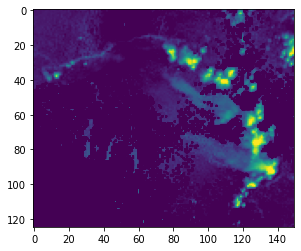

In [82]:
plt.imshow(ref_grid[18], vmin=0, vmax=40)

In [33]:
from utils import plotting; from importlib import reload; reload(plotting)

<module 'utils.plotting' from '/Users/jonesw/python/example_notebooks/utils/plotting.py'>

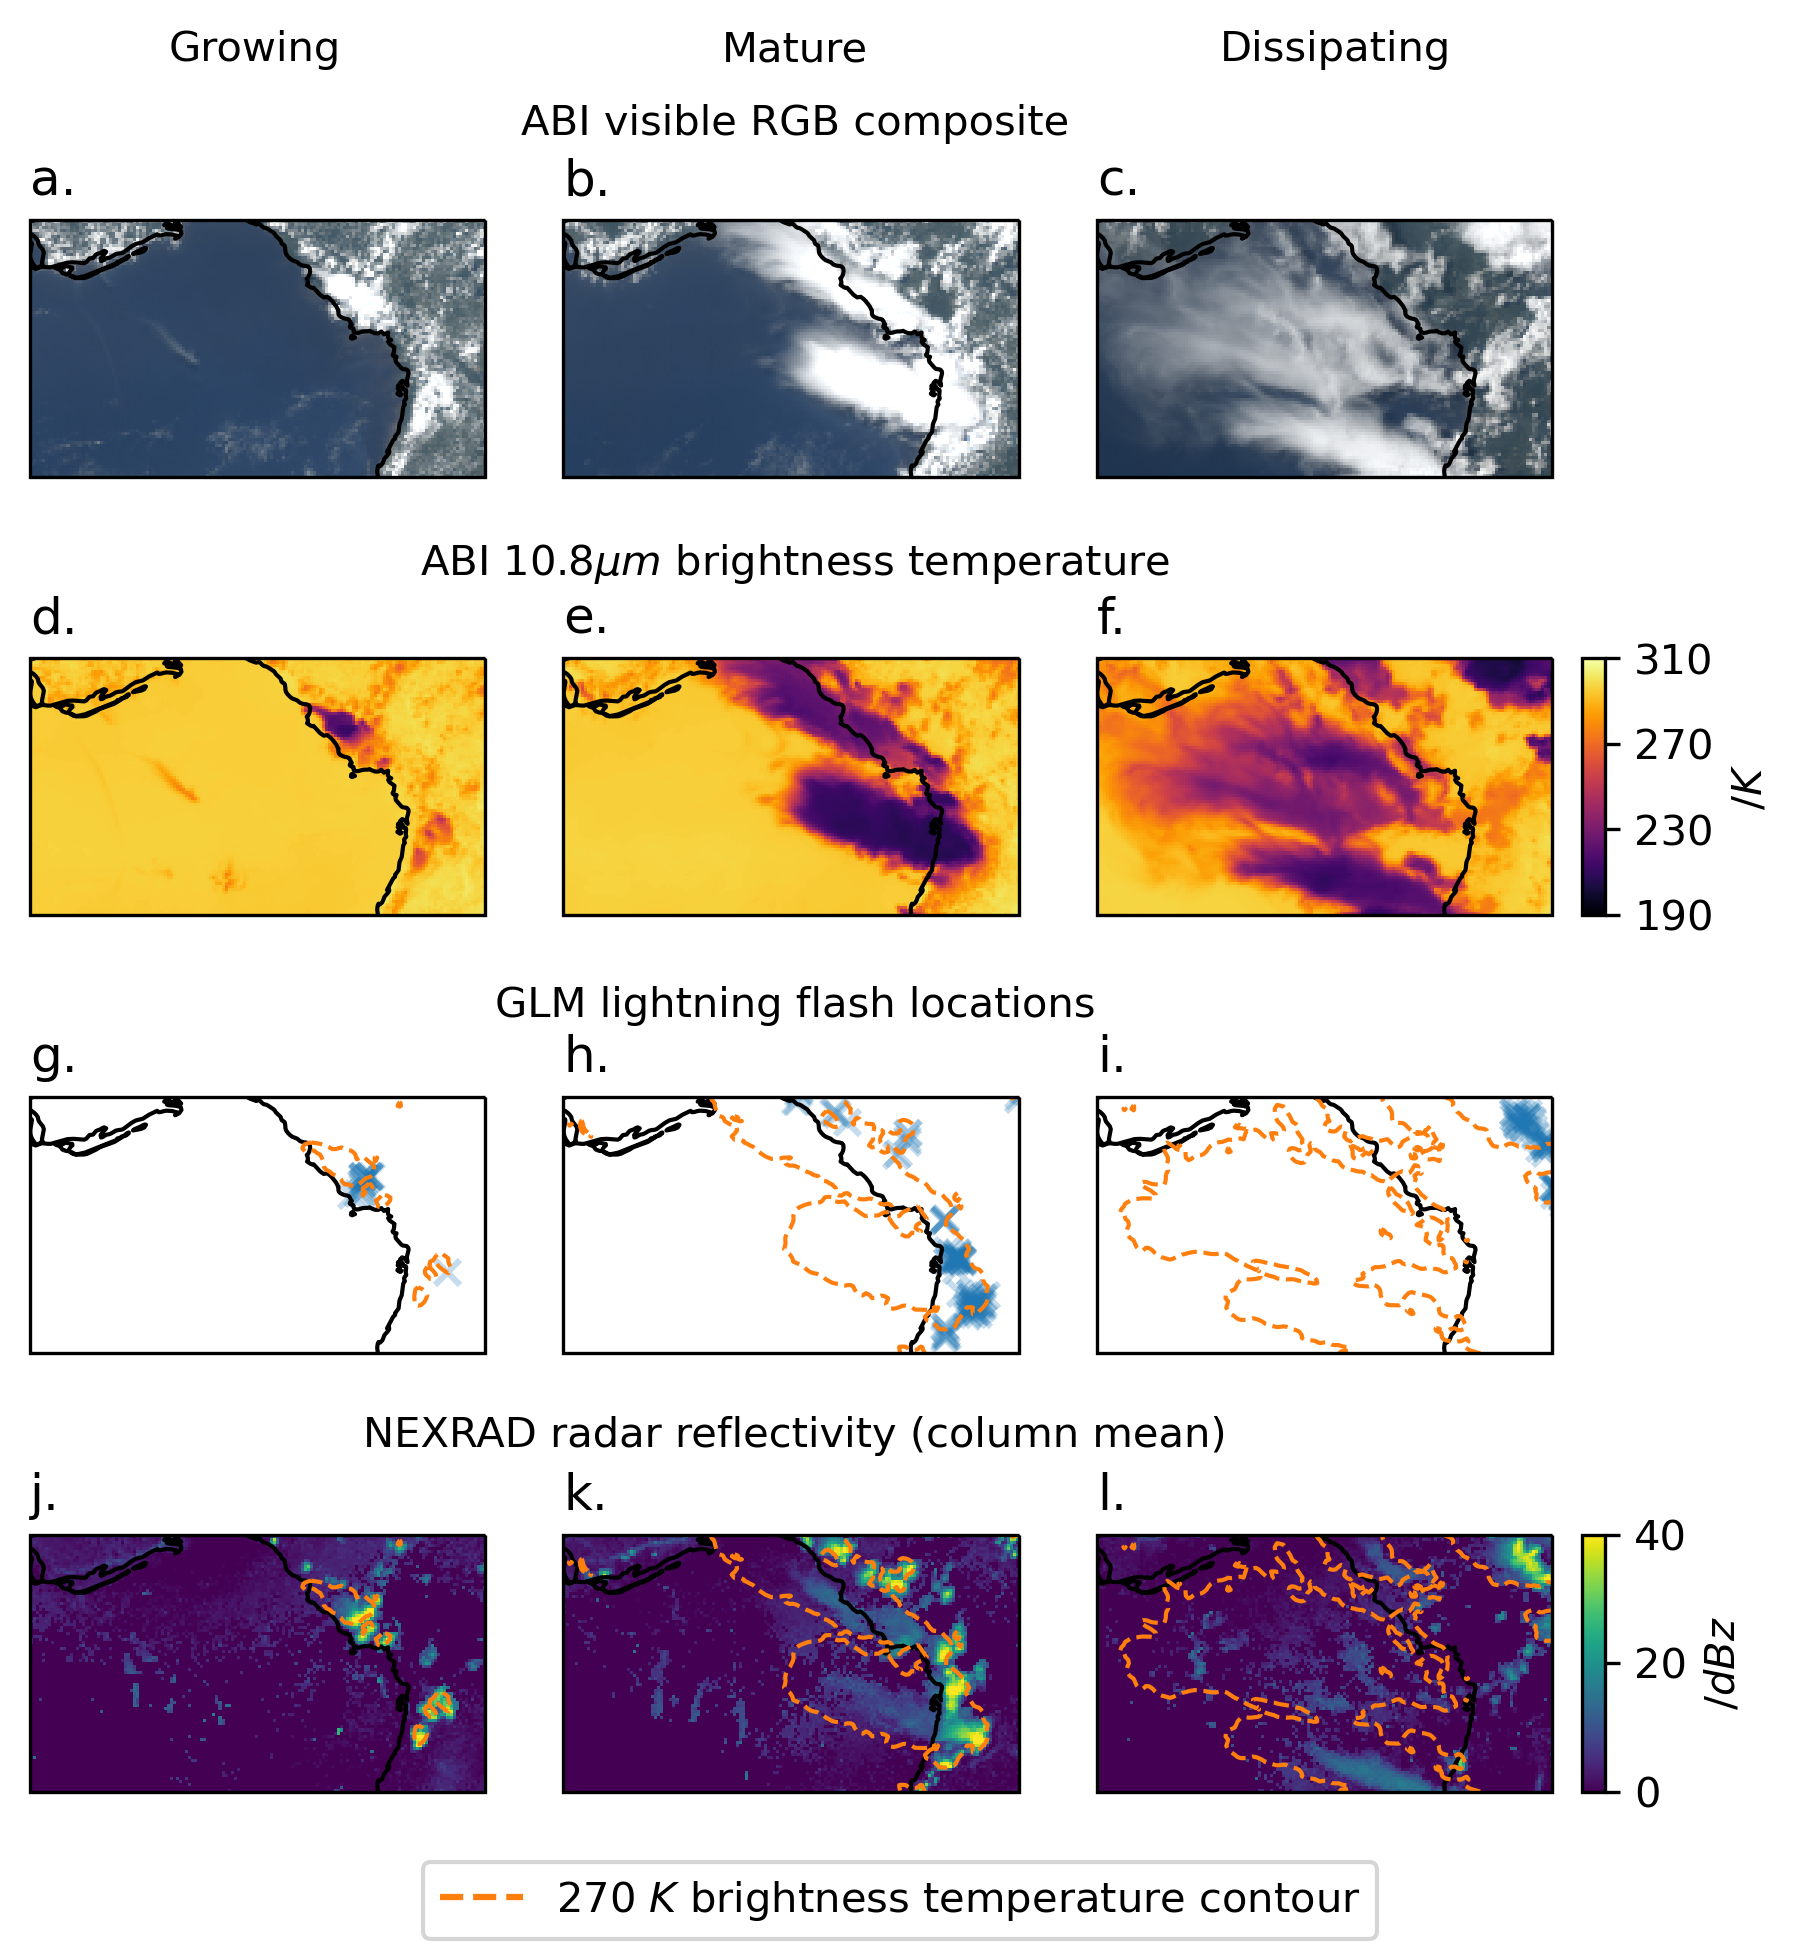

In [228]:
fig = goes_figure(goes_ds.isel({'y':slice(25,-15)}), dpi=300, figsize=(6,7))

ax1 = fig.subplot(431)
ax1.coastlines()
ax1.imshow(abi.get_abi_rgb(goes_ds.isel({'t':0}))[25:-15])
ax1.set_title('a.', loc='left')
# ax1.set_title('Growing')

ax2 = fig.subplot(432)
ax2.coastlines()
ax2.imshow(abi.get_abi_rgb(goes_ds.isel({'t':18}))[25:-15])
ax2.set_title('b.', loc='left')
# ax2.set_title('Mature')

ax3 = fig.subplot(433)
ax3.coastlines()
ax3.imshow(abi.get_abi_rgb(goes_ds.isel({'t':-1}))[25:-15])
ax3.set_title('c.', loc='left')
# ax3.set_title('Dissipating')

ax4 = fig.subplot(434)
ax4.coastlines()
ax4.imshow(goes_ds.CMI_C13[0][25:-15], vmin=190, vmax=310, cmap='inferno')
ax4.set_title('d.', loc='left')

ax5 = fig.subplot(435)
ax5.coastlines()
ax5.imshow(goes_ds.CMI_C13[18][25:-15], vmin=190, vmax=310, cmap='inferno')
ax5.set_title('e.', loc='left')

ax6 = fig.subplot(436)
ax6.coastlines()
img = ax6.imshow(goes_ds.CMI_C13[-1][25:-15], vmin=190, vmax=310, cmap='inferno')
cbar = ax6.colorbar(img)
cbar.set_label('/$K$')
cbar.set_ticks([190,230,270,310])
ax6.set_title('f.', loc='left')

ax7 = fig.subplot(437)
ax7.coastlines()
ax7.set_title('g.', loc='left')
ax7.contour(goes_ds.isel({'t':0}).CMI_C13[25:-15], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax7.scatter(glm_xy[0][0], glm_xy[0][1], c=['C00'], marker='x', alpha=0.25)

ax8 = fig.subplot(438)
ax8.coastlines()
ax8.set_title('h.', loc='left')
ax8.contour(goes_ds.isel({'t':18}).CMI_C13[25:-15], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax8.scatter(glm_xy[2][0], glm_xy[2][1], c=['C00'], marker='x', alpha=0.25)

ax9 = fig.subplot(439)
ax9.coastlines()
ax9.set_title('i.', loc='left')
ax9.contour(goes_ds.isel({'t':-1}).CMI_C13[25:-15], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax9.scatter(glm_xy[3][0], glm_xy[3][1], c=['C00'], marker='x', alpha=0.25)

ax10 = fig.subplot(4, 3, 10)
ax10.coastlines()
ax10.set_title('j.', loc='left')
ax10.contour(goes_ds.isel({'t':0}).CMI_C13[25:-15], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax10.imshow(ref_grid[0][25:-15], vmin=0, vmax=40)

ax11 = fig.subplot(4, 3, 11)
ax11.coastlines()
ax11.set_title('k.', loc='left')
ax11.contour(goes_ds.isel({'t':18}).CMI_C13[25:-15], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax11.imshow(ref_grid[18][25:-15], vmin=0, vmax=40)

ax12 = fig.subplot(4, 3, 12)
ax12.coastlines()
ax12.set_title('l.', loc='left')
ax12.contour(goes_ds.isel({'t':-1}).CMI_C13[25:-15], [270], colors=['C01'], linestyles=['--'], linewidths=1)
img2 = ax12.imshow(ref_grid[-1][25:-15], vmin=0, vmax=40)
cbar2 = ax12.colorbar(img2)
cbar2.set_label('/$dBz$')
# cbar2.set_ticks([180,220,260,300])

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['270 $K$ brightness temperature contour'], loc='lower center')

fig.text(0.5, 0.24, 'NEXRAD radar reflectivity (column mean)', ha='center', va='baseline')

fig.text(0.5, 0.445, 'GLM lightning flash locations', ha='center', va='baseline')

fig.text(0.5, 0.655, 'ABI 10.8$\mu m$ brightness temperature', ha='center', va='baseline')

fig.text(0.5, 0.865, 'ABI visible RGB composite', ha='center', va='baseline')

fig.text(0.5, 0.9, 'Mature', ha='center', va='baseline')
fig.text(0.2, 0.9, 'Growing', ha='center', va='baseline')
fig.text(0.8, 0.9, 'Dissipating', ha='center', va='baseline')


plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.85, left=0.075, right=0.95)

Figure 2: GOES ABI imagery for channel 13, WVD, and SWD combinations

Text(0.5, 1.0, 'Split window difference')

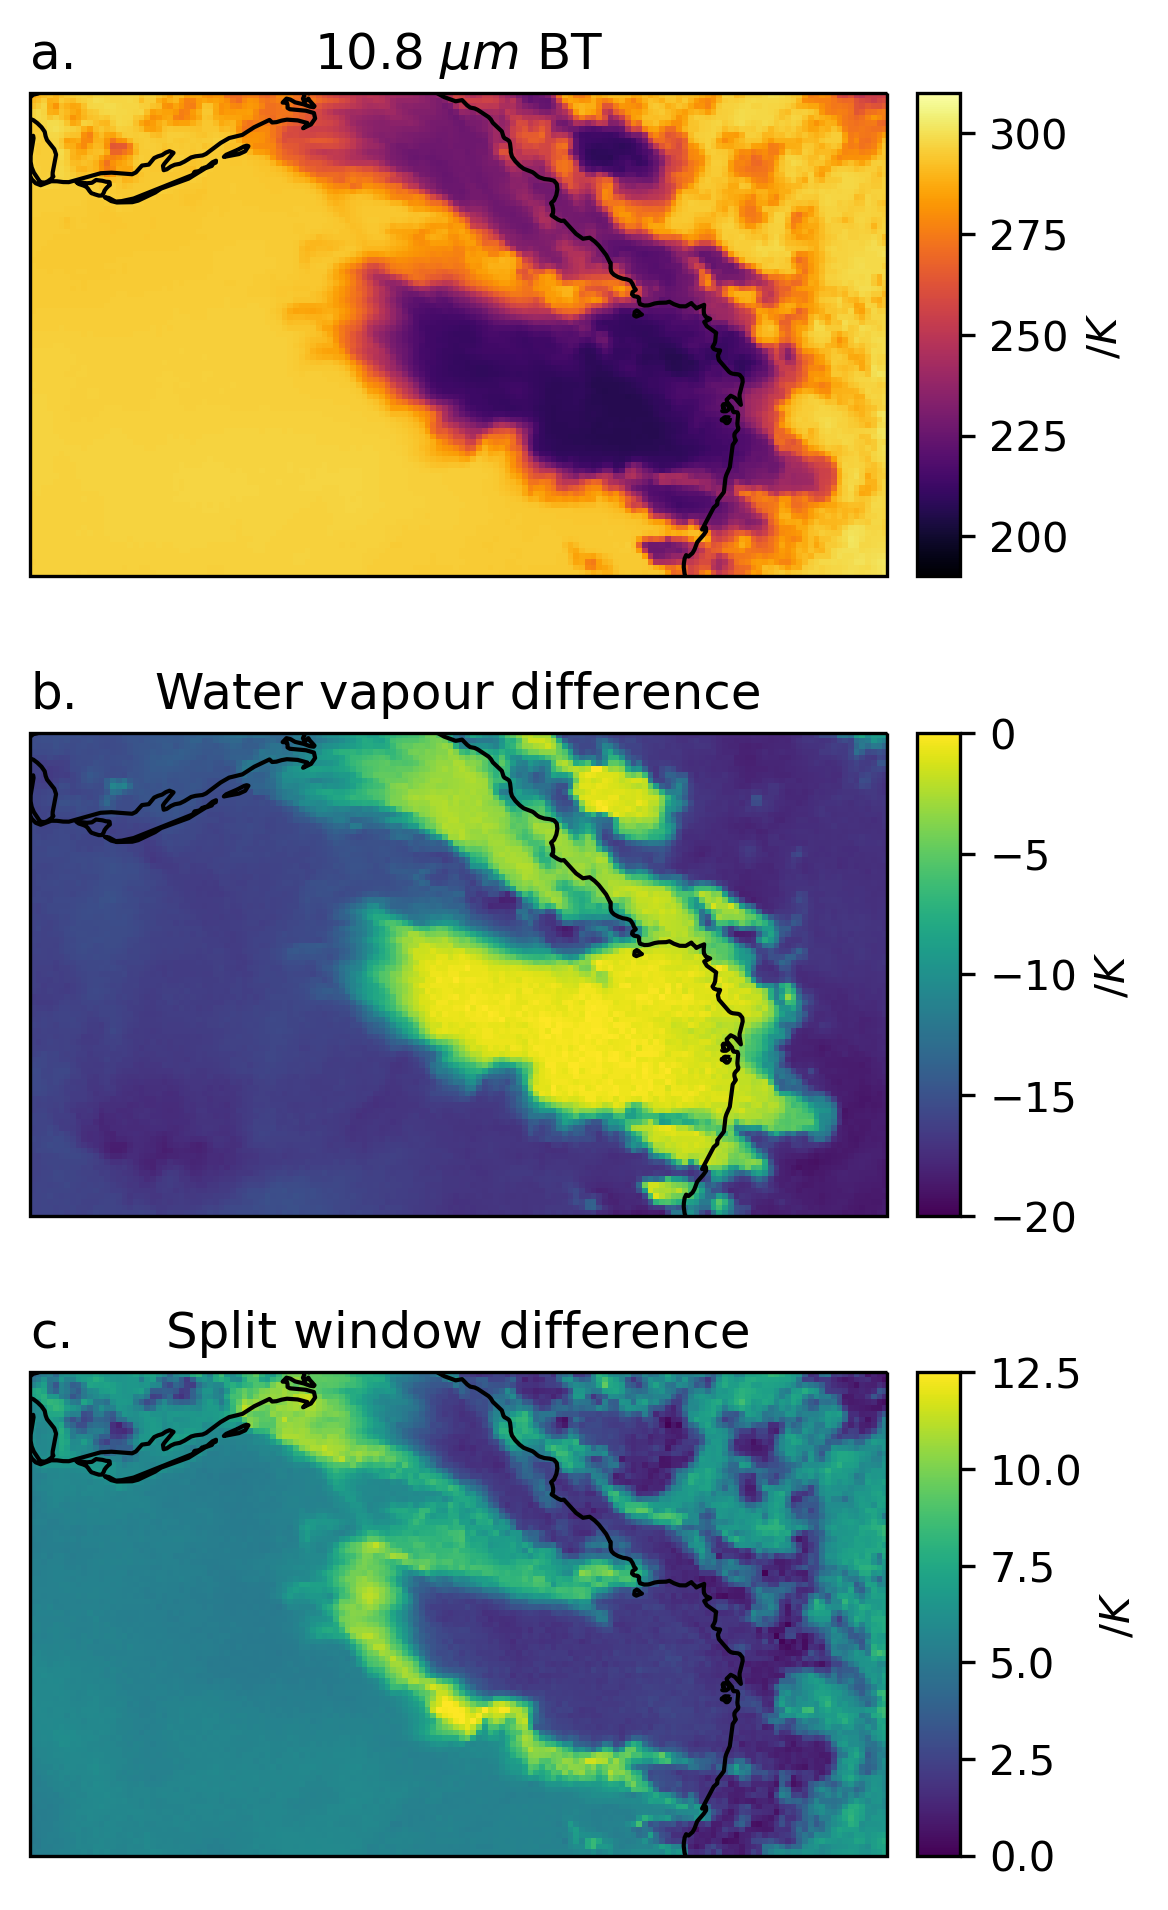

In [127]:
fig = goes_figure(goes_ds.isel({'y':slice(25,-15)}), dpi=300, figsize=(4,8))

ax1 = fig.subplot(311)
ax1.coastlines()
im1 = ax1.imshow(bt[24,25:-15], cmap='inferno', vmin=190, vmax=310)
cbar1 = ax1.colorbar(im1)
cbar1.set_label('/$K$')
# cbar1.set_ticks([190,230,270,310])
ax1.set_title('a.', loc='left')
ax1.set_title('10.8 $\mu m$ BT')

ax2 = fig.subplot(312)
ax2.coastlines()
im2 = ax2.imshow(wvd[24,25:-15], vmin=-20, vmax=0)
cbar2 = ax2.colorbar(im2)
cbar2.set_label('/$K$')
ax2.set_title('b.', loc='left')
ax2.set_title('Water vapour difference')

ax3 = fig.subplot(313)
ax3.coastlines()
im3 = ax3.imshow(swd[24,25:-15], vmin=0, vmax=12.5)
cbar3 = ax3.colorbar(im3)
cbar3.set_label('/$K$')
ax3.set_title('c.', loc='left')
ax3.set_title('Split window difference')


Figure 3: Optical flow vector examples

In [130]:
flow_kwargs = {'pyr_scale':0.5, 'levels':5, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':cv.OPTFLOW_FARNEBACK_GAUSSIAN}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

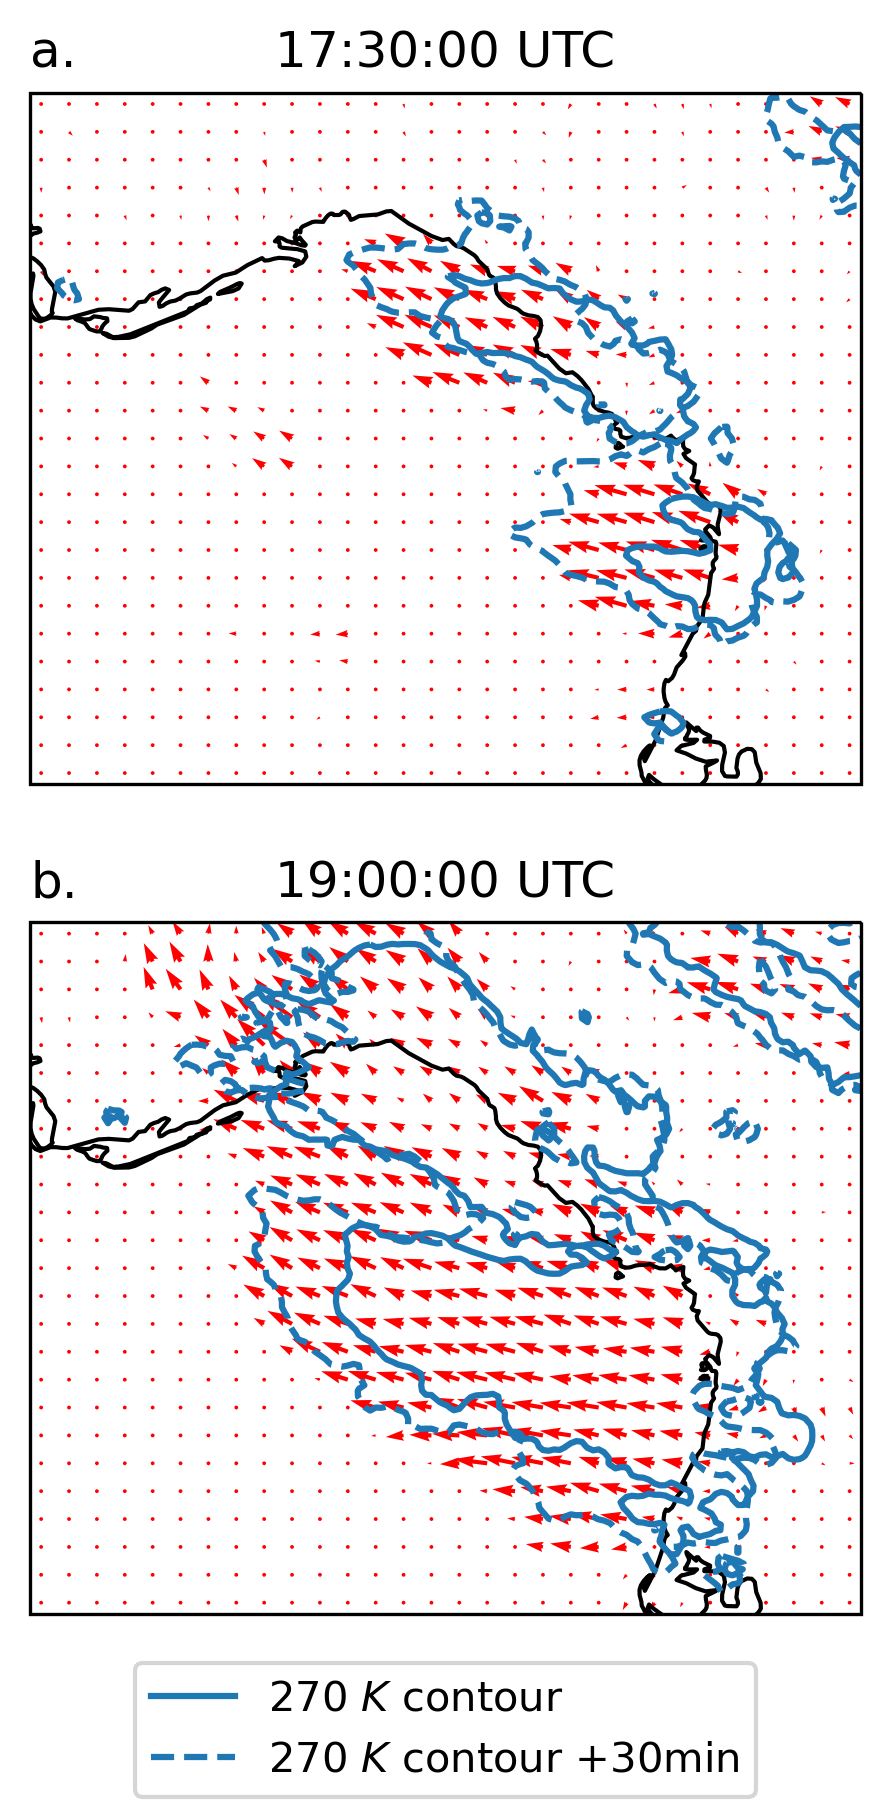

In [230]:
fig = goes_figure(goes_ds, dpi=300, figsize=(4,6.5))
i=6
ax1 = fig.subplot(211)
# ax1.imshow(abi.get_abi_rgb(goes_ds.isel({'t':18})))
ax1.coastlines()
ax1.contour(goes_ds.isel({'t':i}).CMI_C13, [270], colors=['C00'])
ax1.contour(goes_ds.isel({'t':i+6}).CMI_C13, [270], colors=['C00'], linestyles=['--'])
ax1.quiver(flow.flow_for[i,...,0],-flow.flow_for[i,...,1], spacing=5, scale=100, width=0.005, color='r')
ax1.set_title('a.', loc='left')
ax1.set_title('17:30:00 UTC')

ax2 = fig.subplot(212)
i=24
# img2 = ax2.imshow(goes_ds.isel({'t':30}).CMI_C13, cmap='inferno')
ax2.coastlines()
# cbar2 = ax2.colorbar(img2)
# cbar2.set_label('Brightness temperature /K')
ax2.contour(goes_ds.isel({'t':i}).CMI_C13, [270], colors=['C00'])
ax2.contour(goes_ds.isel({'t':i+6}).CMI_C13, [270], colors=['C00'], linestyles=['--'])
ax2.quiver(flow.flow_for[i,...,0],-flow.flow_for[i,...,1], spacing=5, scale=100, width=0.005, color='r')
ax2.set_title('b.', loc='left')
ax2.set_title('19:00:00 UTC')

fig.legend([mlines.Line2D([], [], color='C00'),mlines.Line2D([], [], color='C00', linestyle='--')], 
           ['270 $K$ contour', '270 $K$ contour +30min'], loc='lower center')

plt.subplots_adjust(bottom=0.1)

Figure 4: Detection of growing deep convection

In [142]:
wvd_diff = flow.diff(wvd)/dt[:,np.newaxis,np.newaxis]
bt_diff = flow.diff(bt)/dt[:,np.newaxis,np.newaxis]

In [177]:
# Temp struct onlu performs convolution in the temporal dimension
temp_struct = np.zeros([3,3,3])
temp_struct[:,1,1] = 1

temp_diff = flow.convolve(flow.convolve(wvd_diff, structure=temp_struct, func=lambda x:np.nanmean(x,0)), 
                          structure=temp_struct, func=lambda x:np.nanmax(x,0))

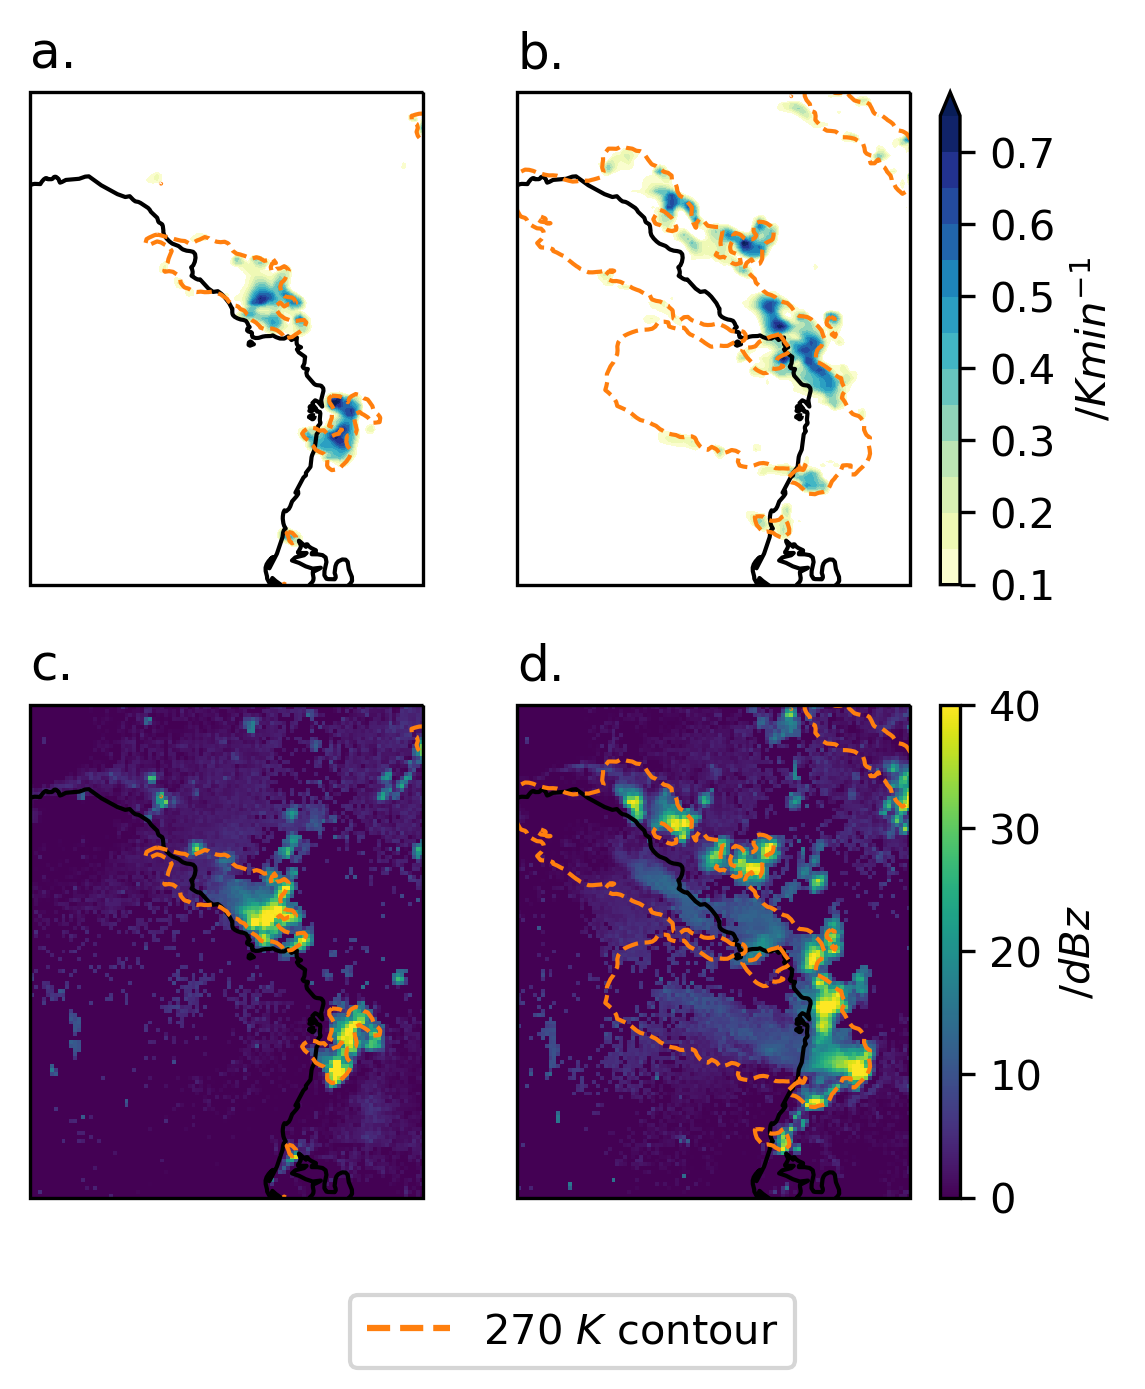

In [231]:
fig = goes_figure(goes_ds.isel({'x':slice(50,None)}), dpi=300, figsize=(4,5))
i1=3
ax1 = fig.subplot(221)
ax1.coastlines()
ax1.contour(goes_ds.isel({'t':i1}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=[1])
c1 = ax1.contourf(temp_diff[i1][:,50:], np.arange(0.1,0.8,0.05), extend='max', cmap='YlGnBu')
ax1.set_title('a.', loc='left')
# ax1.set_title('17:15:00')

# cbar = ax1.colorbar(c1)
# cbar.set_label('/$K min^{-1}$')

ax2 = fig.subplot(222)
i2=18
ax2.coastlines()
ax2.contour(goes_ds.isel({'t':i2}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=[1])
c2 = ax2.contourf(temp_diff[i2][:,50:], np.arange(0.1,0.8,0.05), extend='max', cmap='YlGnBu')
ax2.set_title('b.', loc='left')
# ax2.set_title('19:00:00')

cbar = ax2.colorbar(c2)
cbar.set_label('/$K min^{-1}$')

ax3 = fig.subplot(223)
ax3.coastlines()
ax3.set_title('c.', loc='left')
ax3.contour(goes_ds.isel({'t':i1}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
ax3.imshow(ref_grid[i1][:,50:], vmin=0, vmax=40)

ax4 = fig.subplot(224)
ax4.coastlines()
ax4.set_title('d.', loc='left')
ax4.contour(goes_ds.isel({'t':i2}).CMI_C13[:,50:], [270], colors=['C01'], linestyles=['--'], linewidths=1)
img4 = ax4.imshow(ref_grid[i2][:,50:], vmin=0, vmax=40)

cbar2 = ax4.colorbar(img4)
cbar2.set_label('/$dBz$')

fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['270 $K$ contour'], loc='lower center')

plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=0.1)

Figure 5: Detected anvil area

In [194]:
erode_struct = ndi.generate_binary_structure(2,1)[np.newaxis]
markers = ndi.binary_opening(temp_diff>=0.5, structure=erode_struct)
mask = ndi.binary_erosion((wvd<=-15).data.compute())

In [195]:
inner_field = wvd-swd+wvd_diff*5-bt_diff*5
inner_edges = flow.sobel(np.maximum(np.minimum(inner_field,-5),-15), direction='uphill')

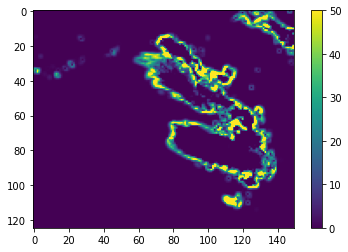

In [196]:
plt.imshow(inner_edges[18], vmin=0, vmax=50)
plt.colorbar()

In [197]:
l_flow = lf.Flow_Func(flow.flow_for[...,0], flow.flow_back[...,0], 
                      flow.flow_for[...,1], flow.flow_back[...,1])

In [198]:
inner_watershed = lf.flow_network_watershed(inner_edges, markers, l_flow, mask=mask, 
                                            structure=ndi.generate_binary_structure(3,1),
                                            debug_mode=True)

Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 404727
Convergence
Iteration: 1
Pixels converged 573920
Convergence
Iteration: 2
Pixels converged 609929
Convergence
Iteration: 3
Pixels converged 647255
Convergence
Iteration: 4
Pixels converged 701788
Convergence
Iteration: 5
Pixels converged 781863
Convergence
Iteration: 6
Pixels converged 860758
Convergence
Iteration: 7
Pixels converged 887161
Convergence
Iteration: 8
Pixels converged 900000
All pixels converged
Filling basins
Joining labels
Max label: 6652
max_markers: 1
Iteration: 1
Remaining labels: 888
Iteration: 2
Remaining labels: 118
Iteration: 3
Remaining labels: 13
Iteration: 4
Remaining labels: 2


In [199]:
outer_field = wvd+swd
outer_edges = flow.sobel(np.maximum(np.minimum(outer_field,-2.5),-7.5), direction='uphill')

In [200]:
outer_watershed = lf.flow_network_watershed(outer_edges, markers, l_flow, mask=mask, 
                                            structure=ndi.generate_binary_structure(3,1),
                                            debug_mode=True)

Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 403388
Convergence
Iteration: 1
Pixels converged 588767
Convergence
Iteration: 2
Pixels converged 623016
Convergence
Iteration: 3
Pixels converged 653019
Convergence
Iteration: 4
Pixels converged 700739
Convergence
Iteration: 5
Pixels converged 804268
Convergence
Iteration: 6
Pixels converged 871009
Convergence
Iteration: 7
Pixels converged 884744
Convergence
Iteration: 8
Pixels converged 899298
Convergence
Iteration: 9
Pixels converged 900000
All pixels converged
Filling basins
Joining labels
Max label: 7752
max_markers: 1
Iteration: 1
Remaining labels: 1126
Iteration: 2
Remaining labels: 172
Iteration: 3
Remaining labels: 22
Iteration: 4
Remaining labels: 2


In [202]:
inner_watershed = ndi.binary_opening(inner_watershed, structure=erode_struct)
outer_watershed = ndi.binary_opening(outer_watershed, structure=erode_struct)
outer_watershed = np.maximum(inner_watershed, outer_watershed)

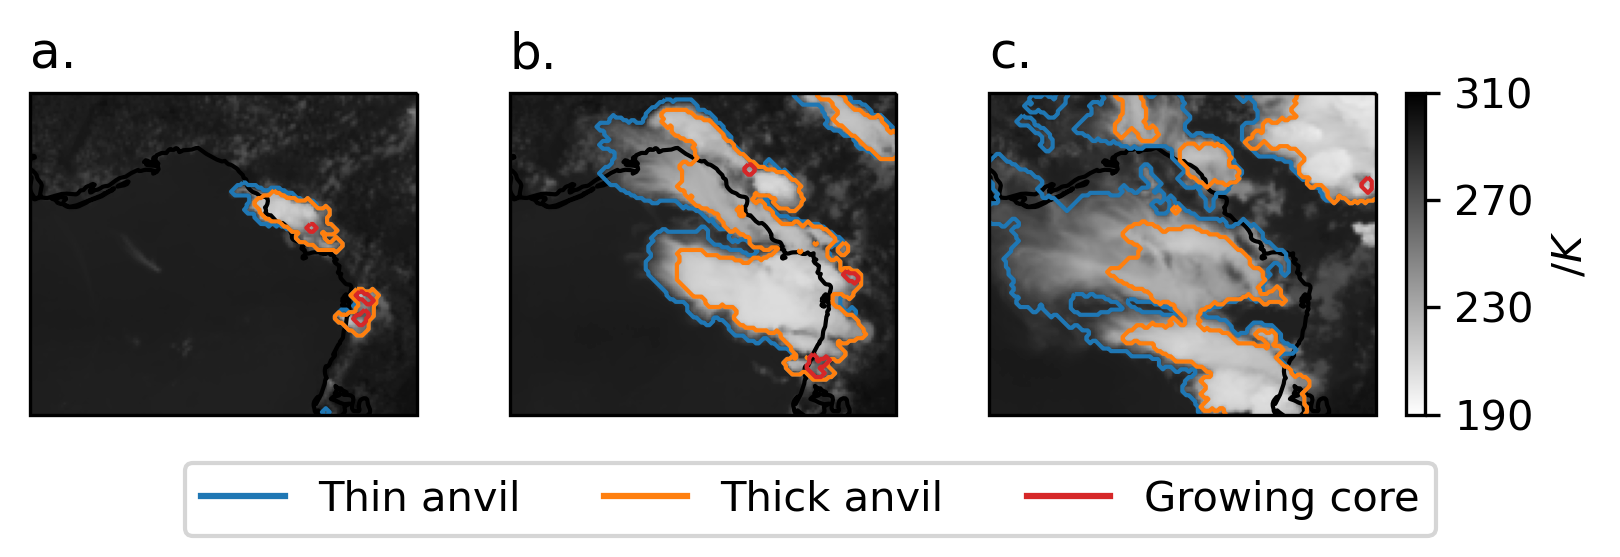

In [227]:
fig = goes_figure(goes_ds, dpi=300, figsize=(6,2))

i1=3
ax1 = fig.subplot(131)
ax1.coastlines()
ax1.imshow(goes_ds.CMI_C13[i1], vmin=190, vmax=310, cmap='binary')
ax1.set_title('a.', loc='left')

ax1.contour(outer_watershed[i1], [0.5], colors=['C00'], linewidths=[1])
ax1.contour(inner_watershed[i1], [0.5], colors=['C01'], linewidths=[1])
ax1.contour(markers[i1], [0.5], colors=['C03'], linewidths=[1])

i2=24
ax2 = fig.subplot(132)
ax2.coastlines()
ax2.imshow(goes_ds.CMI_C13[i2], vmin=190, vmax=310, cmap='binary')
ax2.set_title('b.', loc='left')
ax2.contour(outer_watershed[i2], [0.5], colors=['C00'], linewidths=[1])
ax2.contour(inner_watershed[i2], [0.5], colors=['C01'], linewidths=[1])
ax2.contour(markers[i2], [0.5], colors=['C03'], linewidths=[1])

i3=47
ax3 = fig.subplot(133)
ax3.coastlines()
img = ax3.imshow(goes_ds.CMI_C13[-1], vmin=190, vmax=310, cmap='binary')
cbar = ax3.colorbar(img)
cbar.set_label('/$K$')
cbar.set_ticks([190,230,270,310])
ax3.set_title('c.', loc='left')
ax3.contour(outer_watershed[i3], [0.5], colors=['C00'], linewidths=[1])
ax3.contour(inner_watershed[i3], [0.5], colors=['C01'], linewidths=[1])
ax3.contour(markers[i3], [0.5], colors=['C03'], linewidths=[1])

fig.legend([mlines.Line2D([], [], color='C00'), mlines.Line2D([], [], color='C01'), mlines.Line2D([], [], color='C03')], 
           ['Thin anvil', 'Thick anvil', 'Growing core'], loc='lower center', ncol=3)

plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=0.1)

Figure 6: GLM validation. Histograms of false and missed detections for markers, WVD and detected field

In [260]:
def filter_labels_by_length(labels, min_length):
    bins = np.cumsum(np.bincount(labels.ravel()))
    args = np.argsort(labels.ravel())
    object_lengths = np.array([o[0].stop-o[0].start for o in ndi.find_objects(labels)])
    counter = 1
    for i in range(bins.size-1):
        if bins[i+1]>bins[i]:
            if object_lengths[i]<3:
                labels.ravel()[args[bins[i]:bins[i+1]]] = 0
            else:
                labels.ravel()[args[bins[i]:bins[i+1]]] = counter
                counter += 1
    return labels


In [292]:
marker_labels = filter_labels_by_length(lf.flow_label(markers, l_flow), 3)
wvd_labels = filter_labels_by_length(lf.flow_label(wvd>=-5, l_flow), 3)
inner_labels = filter_labels_by_length(lf.flow_label(inner_watershed, l_flow), 3)
outer_labels = filter_labels_by_length(lf.flow_label(outer_watershed, l_flow), 3)

/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)
/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


In [295]:
glm_distance = ndi.morphology.distance_transform_edt(np.logical_not(glm_grid), sampling=(2,1,1))
marker_distance = ndi.morphology.distance_transform_edt(marker_labels==0, sampling=(2,1,1))
wvd_distance = ndi.morphology.distance_transform_edt(wvd_labels==0, sampling=(2,1,1))
anvil_distance = ndi.morphology.distance_transform_edt(inner_labels==0, sampling=(2,1,1))


In [269]:
def get_min_dist_for_objects(distance_array, labels):
    bins = np.cumsum(np.bincount(labels.ravel()))
    args = np.argsort(labels.ravel())
    dists = np.full(bins.size-1, np.nan)
    mask_count = np.full(bins.size-1, np.nan)
    for i in range(bins.size-1):
        if bins[i+1]>bins[i]:
            mask_count[i] = bins[i+1]-bins[i]
            dists[i] = np.min(distance_array.ravel()[args[bins[i]:bins[i+1]]])
    return dists, mask_count

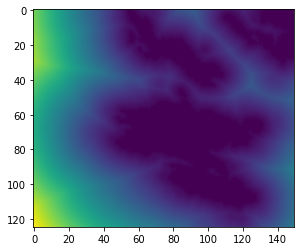

In [286]:
plt.imshow(wvd_distance[36])

markers:
n = 15
0.49399609047752024
0.9333333333333333
WVD:
n = 10
0.9652874201610663
0.7999999999999999
anvil:
n = 2
0.9941682865870592
1.0
total GLM flashes:  3601.0


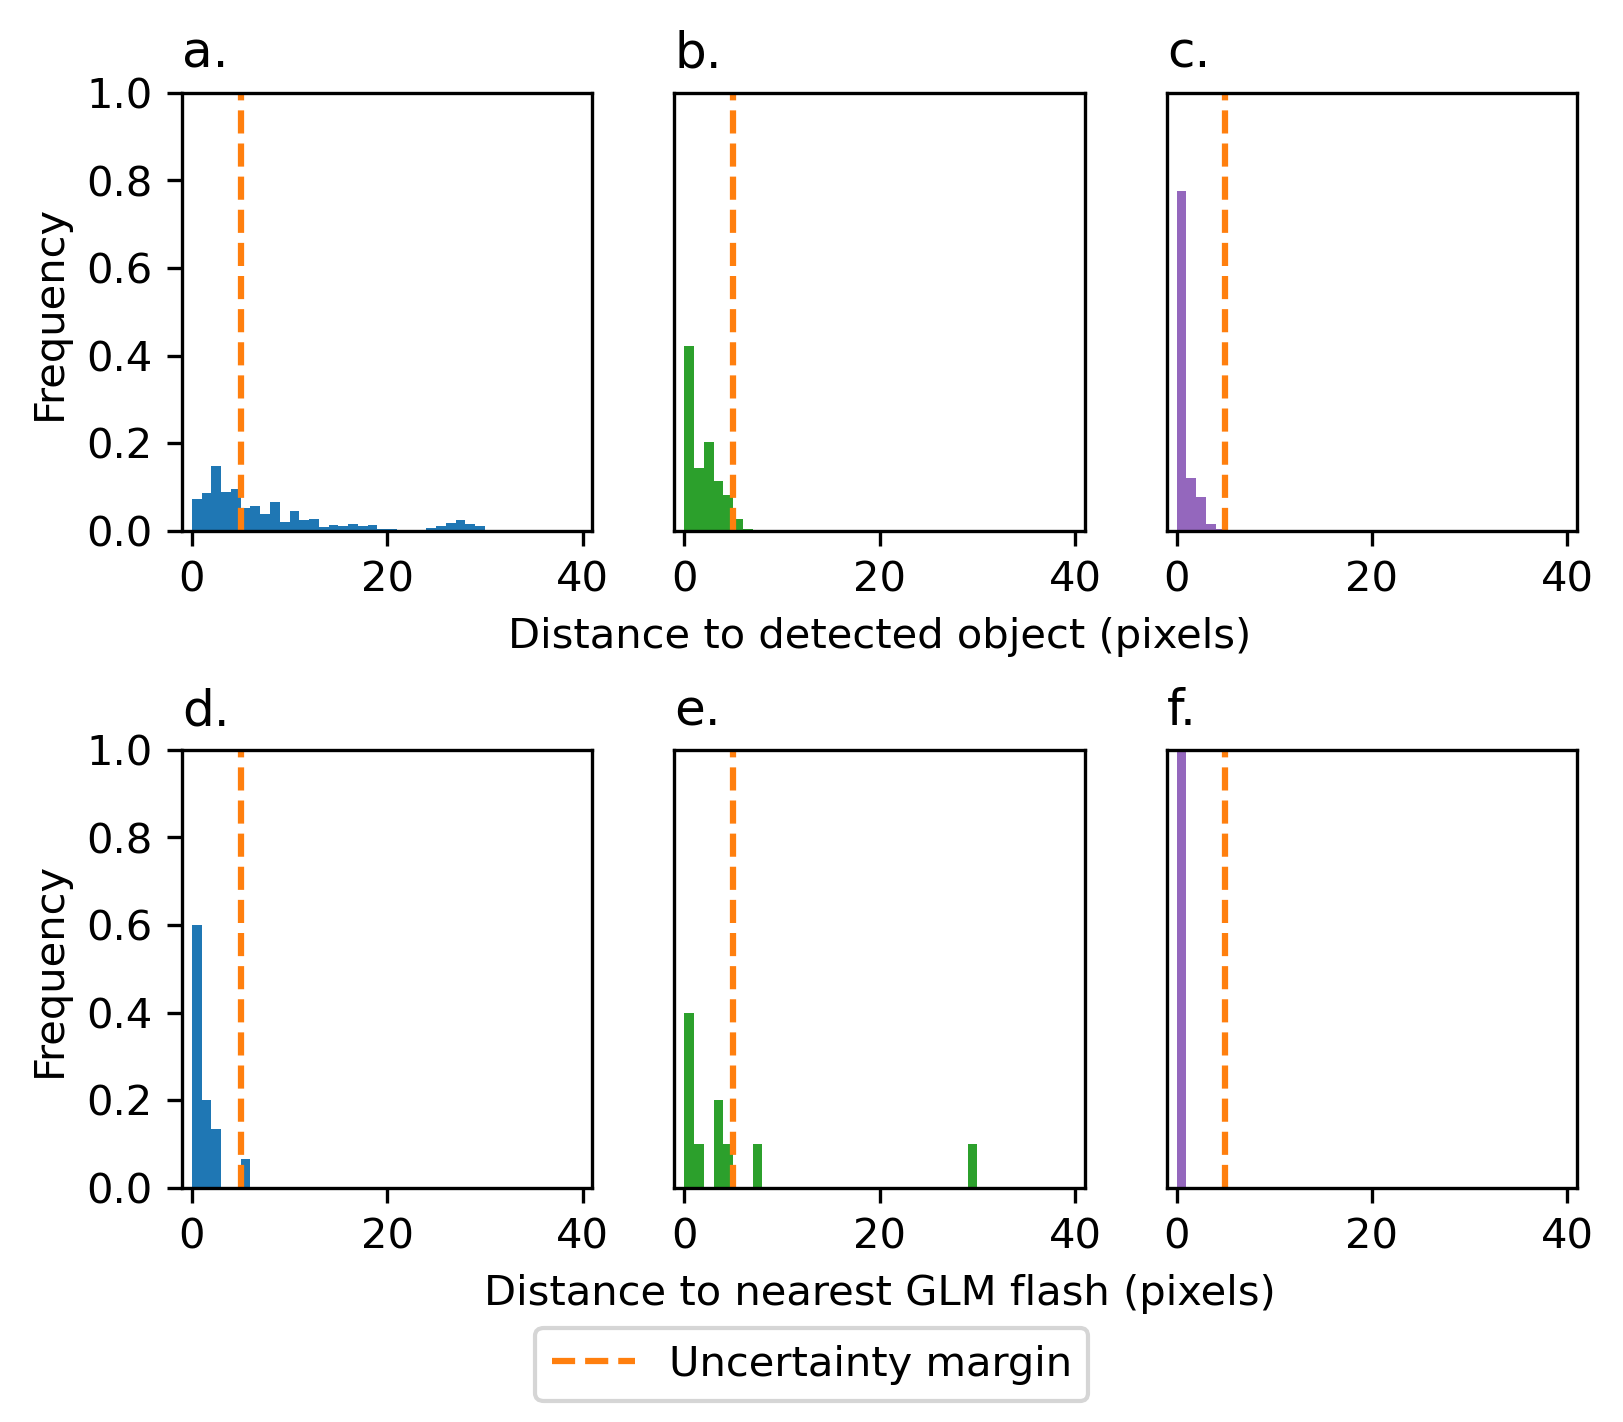

In [324]:
fig = plt.figure(dpi=300, figsize=(6,5))

plt.subplot(231)
h1 = plt.hist(marker_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')

plt.subplot(232)
h3 = plt.hist(wvd_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True, color='C02')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to WVD')
plt.title('b.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([])
plt.xlim([-1,41])
plt.xlabel('Distance to detected object (pixels)')

plt.subplot(233)
h5 = plt.hist(anvil_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True, color='C04')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest anvil')
plt.title('c.', loc='left')
# plt.ylabel('Frequency')
plt.yticks([])
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to detected anvil (pixels)')


plt.subplot(234)
h2 = plt.hist(get_min_dist_for_objects(glm_distance, marker_labels)[0], bins=40, range=[0,40], density=True)
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')


plt.subplot(235)
h4 = plt.hist(get_min_dist_for_objects(glm_distance, wvd_labels)[0], bins=40, range=[0,40], density=True, color='C02')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('WVD distance to nearest GLM flash')
plt.title('e.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([])
plt.xlim([-1,41])
plt.xlabel('Distance to nearest GLM flash (pixels)')


plt.subplot(236)
h6 = plt.hist(get_min_dist_for_objects(glm_distance, inner_labels)[0], bins=40, range=[0,40], density=True, color='C04')
plt.plot([5,5],[0,1],c='C01',linestyle='--')
# plt.title('Anvil distance to nearest GLM flash')
plt.title('f.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')

fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Uncertainty margin'], loc='lower center')

plt.subplots_adjust(hspace=0.5, bottom=0.15)

print('markers:')
print('n =', marker_labels.max())
print(np.sum(h1[0][:5]))
print(np.sum(h2[0][:5]))

print('WVD:')
print('n =', wvd_labels.max())
print(np.sum(h3[0][:5]))
print(np.sum(h4[0][:5]))

print('anvil:')
print('n =', inner_labels.max())
print(np.sum(h5[0][:5]))
print(np.sum(h6[0][:5]))

print('total GLM flashes: ', np.sum(glm_grid.data))
